In [7]:
import numpy as np
import pandas as pd
import gmaps
from keysTkingdom.g_api import gapi_key
import PIL.Image as Image
gmaps.configure(api_key=gapi_key)

In [2]:
def convert_to_cartesian(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi /180
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return x, y, z

def convert_to_lat_lon(x, y, z):
    lon = np.arctan2(y, x) * 180 / np.pi
    r = np.sqrt(x **2 + y ** 2)
    lat = np.arctan2(z, r) * 180/ np.pi
    return lat, lon

In [3]:
group_coords = pd.read_csv('./group_coords.csv')

In [4]:
group_coords['Weekday'] = group_coords[[col for col in group_coords.columns if 'Weekday' in col]].apply(lambda x: convert_to_cartesian(*x), axis=1)
group_coords['Weekend'] = group_coords[[col for col in group_coords.columns if 'Weekend' in col]].apply(lambda x: convert_to_cartesian(*x), axis=1)

In [5]:
weekday_centroid = tuple(map(np.mean, zip(*group_coords['Weekday'])))
weekend_centroid = tuple(map(np.mean, zip(*group_coords['Weekend'])))
weekday_centroid_coords = convert_to_lat_lon(*weekday_centroid)
weekend_centroid_coords = convert_to_lat_lon(*weekend_centroid)

print(weekday_centroid_coords, weekend_centroid_coords)

(47.635172536202646, -122.28242800060502) (47.635898951803775, -122.33695972606144)


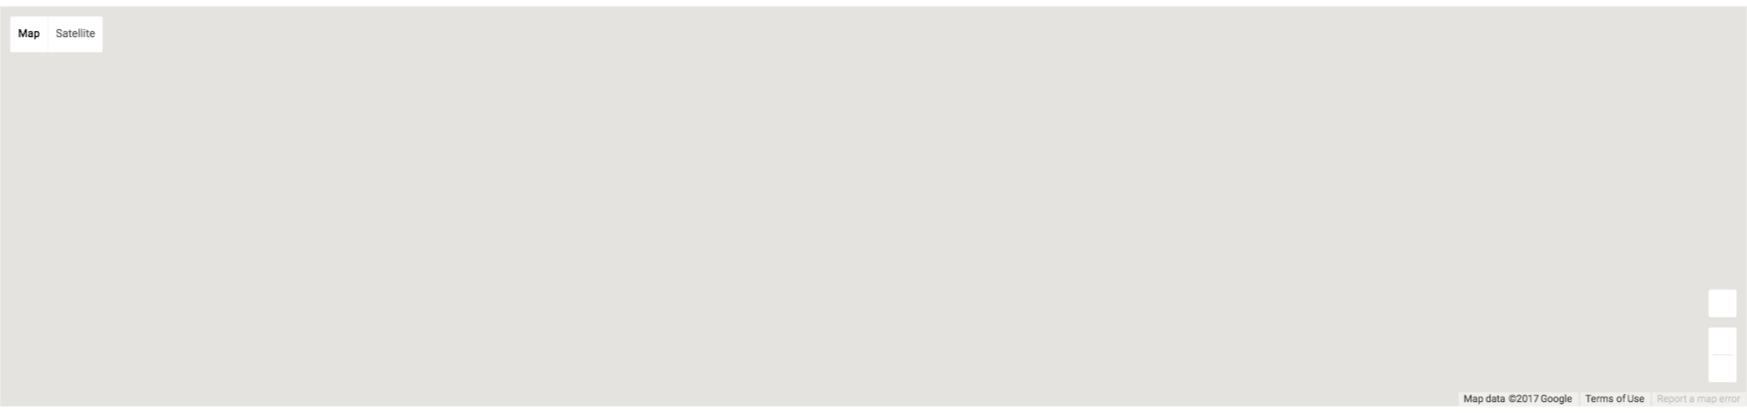

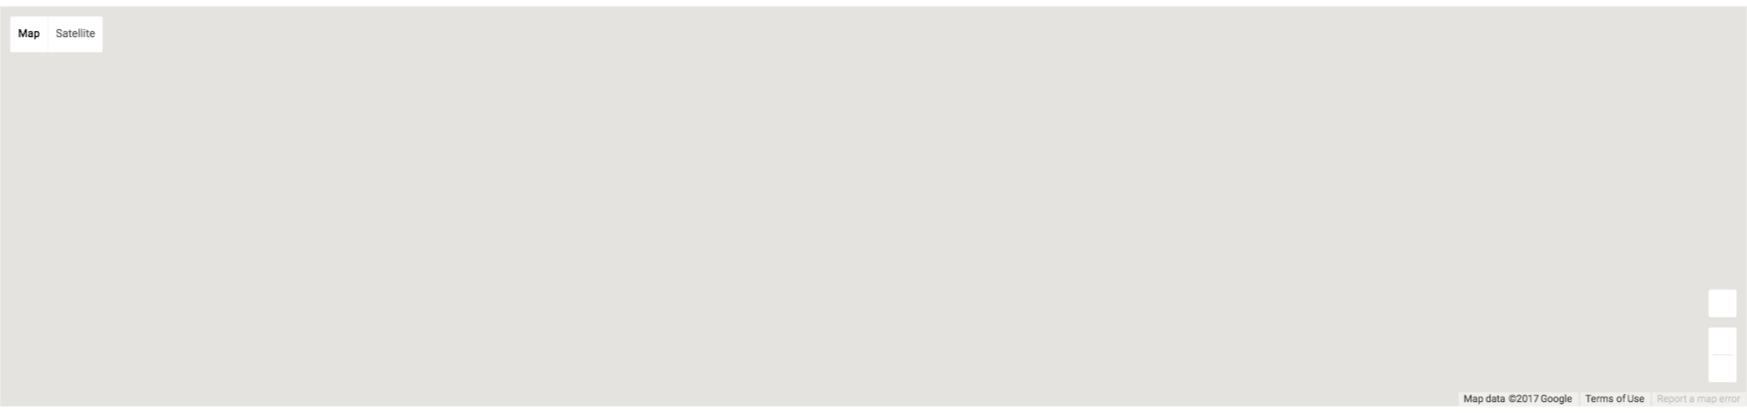

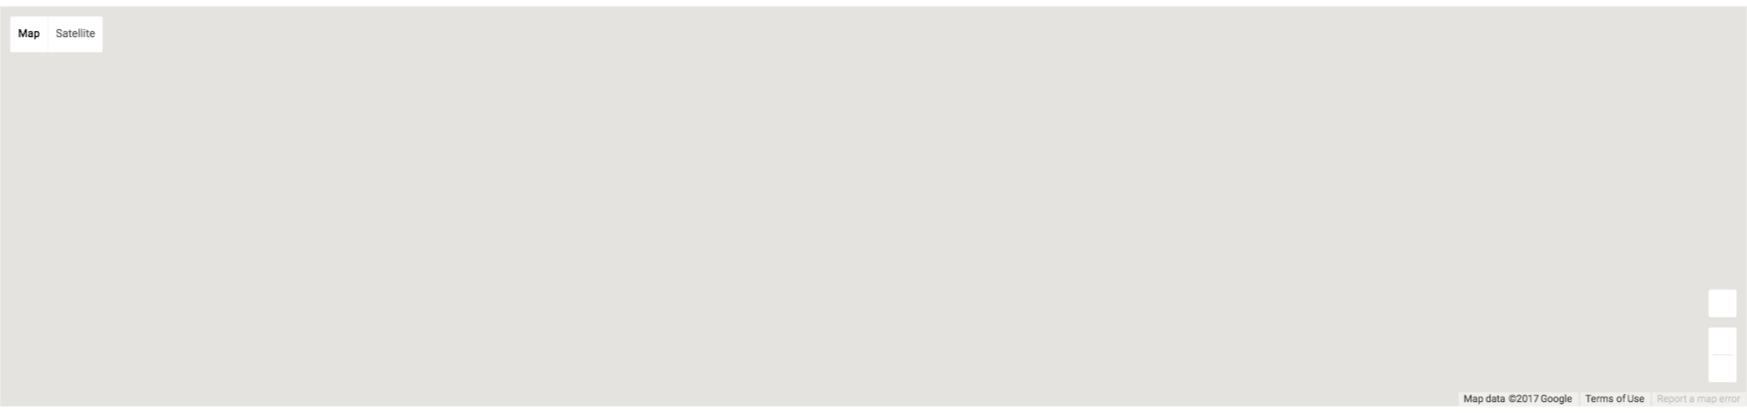

In [6]:
m = gmaps.Map()
marker = gmaps.marker_layer([weekday_centroid_coords, weekend_centroid_coords])
m.add_layer(marker)
m

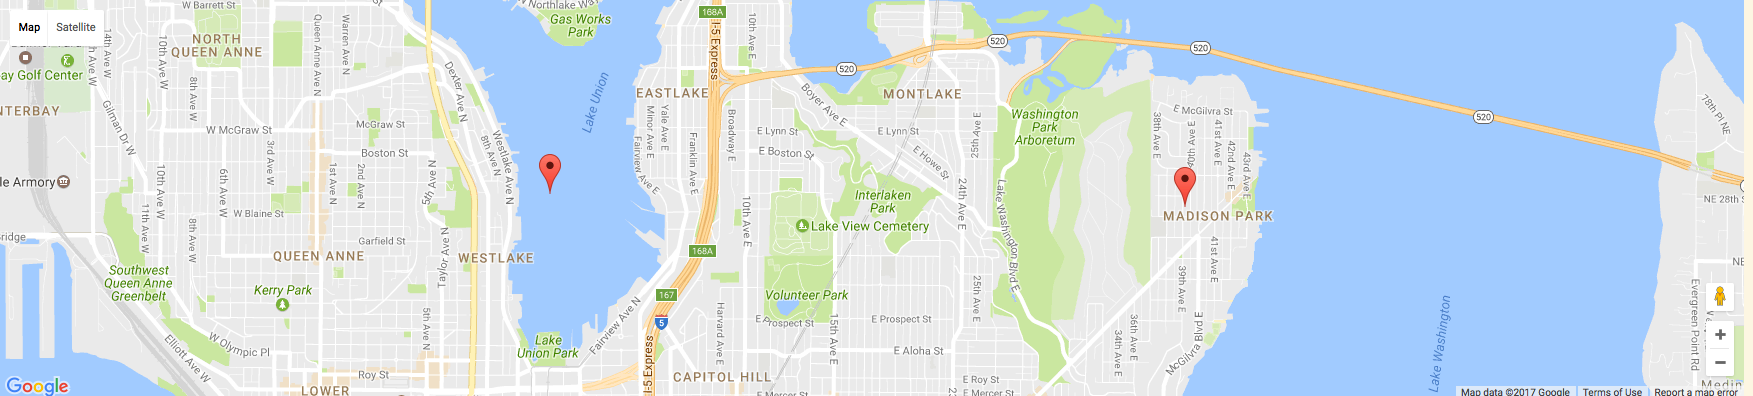

In [9]:
Image.open('./map_render.png')